# 1. Importación de módulos

In [30]:
# manipulacion
import numpy as np
import pandas as pd

# visualizacion
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.gridspec as gs
import plotly.express as px
import seaborn as sns

# reduccion de dimensionalidad
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# clustering
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans

# interfaz
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all";

# 2. Importación del dataset

In [2]:
# importación de datos, seteo de NaNs (para no perder el haplotipo NA) y de índices utilizando las columnas 'lote' e 'individuo'
data_1_raw = pd.read_csv(
    filepath_or_buffer = '../medidas/merge/merge_20221008.csv',
    low_memory = False,
    keep_default_na = False,
    na_values = '',
    index_col = ['Lote', 'Individuo'])

# renombre de algunas columnas e índices a minúsculas
data_1_raw.rename(columns = {'Morfotipo': 'morfotipo', 'Labio': 'labio'}, inplace = True)
data_1_raw.rename_axis(index = str.lower, inplace = True)

# printeo del dataset original
data_1_raw.head(5)

AE    LE     AT     LT    AA    LA    NV morfotipo  labio  \
lote individuo                                                                
96   1          6.11  2.22  13.95  10.39  8.19  6.99  5.30        LU      1   
     2          5.69  1.45  11.68   8.34  6.45  5.89  5.00        LU      1   
     5          6.14  1.80  13.72  10.00  8.13  6.08  5.12        LU      1   
     6          6.54  2.18  11.66   9.21  6.66  4.93  5.47        LU      0   
99   1          6.01  1.58  12.59   9.09  6.92  6.61  5.15        LU      1   

               cox1-rrnL  
lote individuo            
96   1                AA  
     2                HG  
     5               NaN  
     6               NaN  
99   1                HG

# 3. Limpieza, creación de variables y exploración

## 3.1. Limpieza

In [3]:
# filtración de individuos juveniles (ancho total menor a 8 milímetros o ausencia de labio) y eliminación de la columna 'labio'
data_2_adult = data_1_raw[np.logical_or(data_1_raw.labio == 1, data_1_raw.AT >= 8)].loc[:, data_1_raw.columns != 'labio']
data_2_adult.head(5)

AE    LE     AT     LT    AA    LA    NV morfotipo cox1-rrnL
lote individuo                                                                
96   1          6.11  2.22  13.95  10.39  8.19  6.99  5.30        LU        AA
     2          5.69  1.45  11.68   8.34  6.45  5.89  5.00        LU        HG
     5          6.14  1.80  13.72  10.00  8.13  6.08  5.12        LU       NaN
     6          6.54  2.18  11.66   9.21  6.66  4.93  5.47        LU       NaN
99   1          6.01  1.58  12.59   9.09  6.92  6.61  5.15        LU        HG

## 3.2. Creación de *features*

### 3.2.1. *Dummies*

In [4]:
# creación de dummies de morfotipo
data_3_dummy = pd.get_dummies(
    data_2_adult,
    columns = ['morfotipo'],
    drop_first = True,
    prefix = '',
    prefix_sep= '')

### 3.2.2. Haplogrupos

In [5]:
# creación de diccionario de haplotipos (clave) por haplogrupos (valor)
ht = ['AA', 'AB', 'BA', 'CA', 'DA', 'EA', 'FA', 'LA', 'NA', 'OA', 'JH', 'KI', 'GC', 'GD', 'GE', 'GF', 'HG', 'IG', 'MG']
hg = ['0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '1', '1', '1', '1', '2', '2', '2']
hg_ht_rep = dict(zip(ht, hg))

# creación de un dataset nuevo agregando la columna de haplogrupos
data_4_haplogrupo = data_3_dummy.assign(haplogrupo = data_3_dummy['cox1-rrnL'].replace(hg_ht_rep))

### 3.2.3. *Ratios*

In [6]:
data_5_ratio = data_4_haplogrupo

# ratios
# cada parte sobre sí misma
data_5_ratio['LE/AE'] = data_5_ratio['LE']/data_5_ratio['AE'] # Espira
data_5_ratio['LT/AT'] = data_5_ratio['LT']/data_5_ratio['AT'] # Total
data_5_ratio['LA/AA'] = data_5_ratio['LA']/data_5_ratio['AA'] # Abertura

# espira / total
data_5_ratio['LE/LT'] = data_5_ratio['LE']/data_5_ratio['LT'] # Largo
data_5_ratio['AE/AT'] = data_5_ratio['AE']/data_5_ratio['AT'] # Ancho

# abertura / total
data_5_ratio['LA/LT'] = data_5_ratio['LA']/data_5_ratio['LT'] # Largo
data_5_ratio['AA/AT'] = data_5_ratio['AA']/data_5_ratio['AT'] # Ancho

# espira / abertura
data_5_ratio['LE/LA'] = data_5_ratio['LE']/data_5_ratio['LA'] # Largo
data_5_ratio['AE/AA'] = data_5_ratio['AE']/data_5_ratio['AA'] # Ancho

# reorden de las columnas
data_5_ratio = data_5_ratio[['AE', 'LE', 'AT', 'LT', 'AA', 'LA', 'NV', 'LU', 'LB', 'LE/AE', 'LT/AT', 'LA/AA', 'LE/LT', 'AE/AT', 'LA/LT', 'AA/AT', 'LE/LA', 'AE/AA', 'cox1-rrnL', 'haplogrupo']]

### 3.2.4. Creación de máscaras

In [7]:
# creación de variables para enmascarar los análisis (los morfotipos quedan afuera porque no performan bien)
medidas = ['AE', 'LE', 'AT', 'LT', 'AA', 'LA', 'NV']#, 'LU', 'LB']
ratios = ['LE/AE', 'LT/AT', 'LA/AA', 'LE/LT', 'AE/AT', 'LA/LT', 'AA/AT', 'LE/LA', 'AE/AA']#, 'LU', 'LB']
med_rat = list(dict.fromkeys(medidas + ratios)) # para eliminar elementos duplicados de una lista

# printeo de las variables
print(f'''Variables de medidas ({len(medidas)}): {medidas}
Variables de ratios ({len(ratios)}): {ratios}
Variables de medidas + ratios ({len(med_rat)}): {med_rat}''')

Variables de medidas (7): ['AE', 'LE', 'AT', 'LT', 'AA', 'LA', 'NV']
Variables de ratios (9): ['LE/AE', 'LT/AT', 'LA/AA', 'LE/LT', 'AE/AT', 'LA/LT', 'AA/AT', 'LE/LA', 'AE/AA']
Variables de medidas + ratios (16): ['AE', 'LE', 'AT', 'LT', 'AA', 'LA', 'NV', 'LE/AE', 'LT/AT', 'LA/AA', 'LE/LT', 'AE/AT', 'LA/LT', 'AA/AT', 'LE/LA', 'AE/AA']


## 3.3. Exploración

### 3.3.1. Visualización de datos tabulados

In [8]:
# preview del dataset final
data_5_ratio

AE    LE     AT     LT    AA    LA    NV  LU  LB     LE/AE  \
lote individuo                                                                 
96   1          6.11  2.22  13.95  10.39  8.19  6.99  5.30   1   0  0.363339   
     2          5.69  1.45  11.68   8.34  6.45  5.89  5.00   1   0  0.254833   
     5          6.14  1.80  13.72  10.00  8.13  6.08  5.12   1   0  0.293160   
     6          6.54  2.18  11.66   9.21  6.66  4.93  5.47   1   0  0.333333   
99   1          6.01  1.58  12.59   9.09  6.92  6.61  5.15   1   0  0.262895   
...              ...   ...    ...    ...   ...   ...   ...  ..  ..       ...   
604  1          6.89  2.06  14.47  11.02  8.45  6.58  5.47   1   0  0.298984   
     3          6.51  1.94  13.55  10.67  7.89  6.27  5.47   1   0  0.298003   
     4          5.93  1.56  13.28   9.58  8.28  6.21  5.00   0   1  0.263069   
612  1          6.60  1.96  13.29  10.16  8.13  5.82  5.36   1   0  0.296970   
     2          5.81  1.77  11.44   8.89  6.60  5.20  5.34   1   0  0.304647   

                   LT/AT     LA/AA     LE/LT     AE/AT     LA/LT     AA/AT  \
lote individuo                                                               
96   1          0.744803  0.853480  0.213667  0.437993  0.672762  0.587097   
     2          0.714041  0.913178  0.173861  0.487158  0.706235  0.552226   
     5          0.728863  0.747847  0.180000  0.447522  0.608000  0.592566   
     6          0.789880  0.740240  0.236699  0.560892  0.535288  0.571184   
99   1          0.722002  0.955202  0.173817  0.477363  0.727173  0.549643   
...                  ...       ...       ...       ...       ...       ...   
604  1          0.761576  0.778698  0.186933  0.476158  0.597096  0.583967   
     3          0.787454  0.794677  0.181818  0.480443  0.587629  0.582288   
     4          0.721386  0.750000  0.162839  0.446536  0.648225  0.623494   
612  1          0.764485  0.715867  0.192913  0.496614  0.572835  0.611738   
     2          0.777098  0.787879  0.199100  0.507867  0.584927  0.576923   

                   LE/LA     AE/AA cox1-rrnL haplogrupo  
lote individuo                                           
96   1          0.317597  0.746032        AA          0  
     2          0.246180  0.882171        HG          2  
     5          0.296053  0.755228       NaN        NaN  
     6          0.442191  0.981982       NaN        NaN  
99   1          0.239032  0.868497        HG          2  
...                  ...       ...       ...        ...  
604  1          0.313070  0.815385       NaN        NaN  
     3          0.309410  0.825095       NaN        NaN  
     4          0.251208  0.716184       NaN        NaN  
612  1          0.336770  0.811808       NaN        NaN  
     2          0.340385  0.880303       NaN        NaN  

[503 rows x 20 columns]

In [9]:
# resumen de info por columna
data_5_ratio.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 503 entries, (96, 1) to (612, 2)
Data columns (total 20 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   AE          503 non-null    float64
 1   LE          503 non-null    float64
 2   AT          503 non-null    float64
 3   LT          503 non-null    float64
 4   AA          503 non-null    float64
 5   LA          503 non-null    float64
 6   NV          503 non-null    float64
 7   LU          503 non-null    uint8  
 8   LB          503 non-null    uint8  
 9   LE/AE       503 non-null    float64
 10  LT/AT       503 non-null    float64
 11  LA/AA       503 non-null    float64
 12  LE/LT       503 non-null    float64
 13  AE/AT       503 non-null    float64
 14  LA/LT       503 non-null    float64
 15  AA/AT       503 non-null    float64
 16  LE/LA       503 non-null    float64
 17  AE/AA       503 non-null    float64
 18  cox1-rrnL   106 non-null    object 
 19  haplogrupo  106 no

In [10]:
# resumen de estadisticas
data_5_ratio[medidas].describe()
data_5_ratio[medidas].describe().to_csv('../tablas/summary.csv')

,AE,LE,AT,LT,AA,LA,NV
count,503.000000,503.000000,503.000000,503.000000,503.000000,503.000000,503.000000
mean,6.209602,1.757734,13.173559,9.734513,7.653559,6.188529,5.158111
std,0.974609,0.371801,1.925269,1.444981,1.217997,0.913692,0.299416
min,3.200000,0.710000,8.050000,6.170000,4.790000,4.150000,4.020000
25%,5.550000,1.500000,11.765000,8.750000,6.755000,5.510000,4.970000
50%,6.240000,1.770000,13.120000,9.680000,7.600000,6.100000,5.200000
75%,6.870000,2.025000,14.480000,10.775000,8.470000,6.735000,5.350000
max,9.040000,3.130000,19.090000,14.450000,11.950000,9.720000,6.000000


### 3.3.2. Grafos de distribución

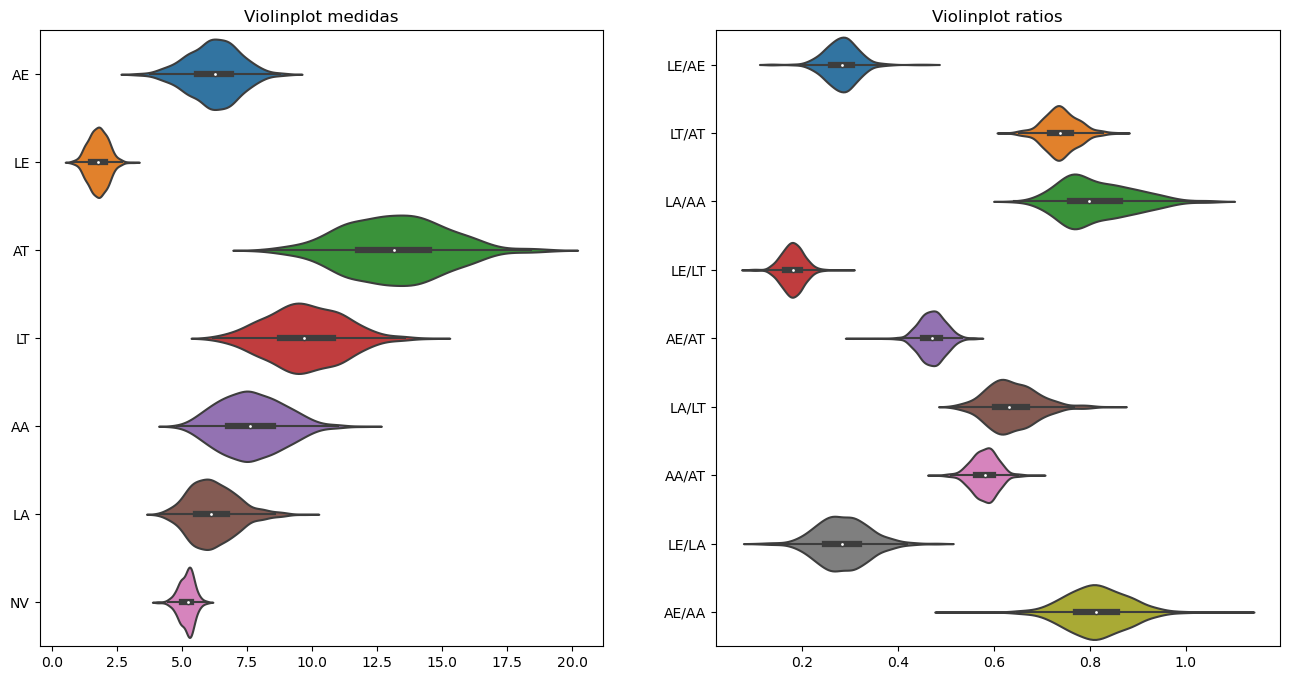

In [11]:
# creacion de la figura (marco general) y la grilla de subplots (1 fila y 2 columnas)
fig = plt.figure(figsize=(16, 8))
GS = gs.GridSpec(nrows = 1, ncols = 2)

# creación del eje 0 en el subplot 0 y ploteo de un violinplot para las medidas iniciales
ax0 = fig.add_subplot(GS[0, 0])
ax0.set(title = 'Violinplot medidas')
sns.violinplot(
    data = data_5_ratio[medidas],
    flierprops={'marker': 'x'},
    orient = 'h',
    scale = 'count',
    inner = 'box',
    ax = ax0)

# creación del eje 1 en el subplot 1 y ploteo de un violinplot para los ratios
ax1 = fig.add_subplot(GS[0, 1])
ax1.set(title = 'Violinplot ratios')
sns.violinplot(
    data = data_5_ratio[ratios],
    flierprops={'marker': 'x'},
    orient = 'h',
    scale = 'count',
    inner = 'box',
    ax = ax1)

# guardado de la figura en un archivo vectorial
fig.savefig('../figuras/violinplots.svg');

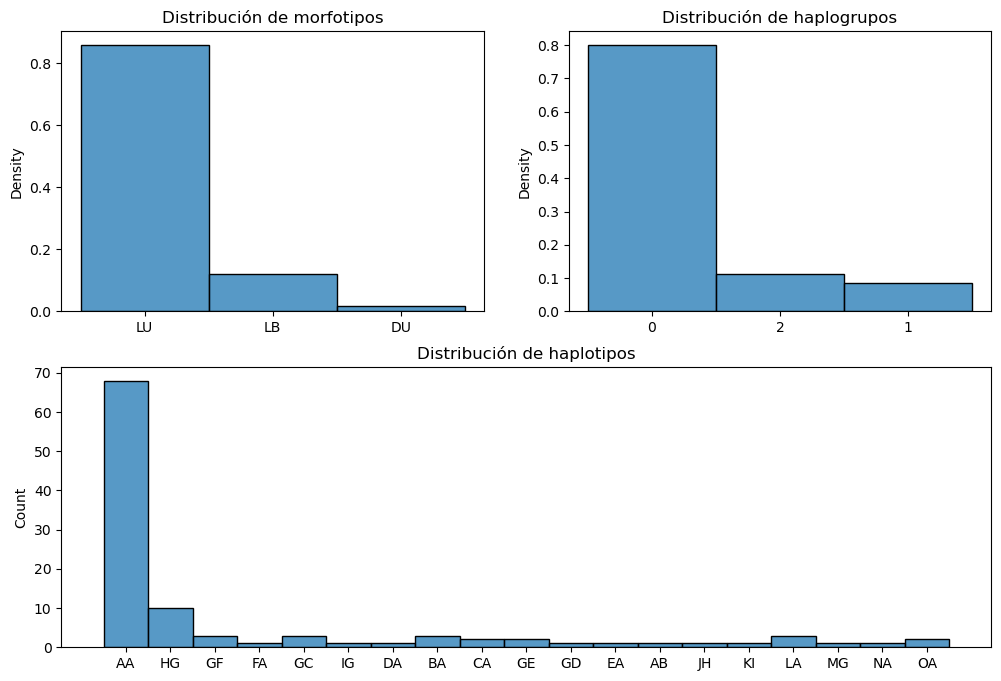

In [12]:
# creacion de la figura (marco general) y la grilla de subplots (2 filas y 2 columnas)
fig = plt.figure(figsize = (12, 8))
GS = gs.GridSpec(nrows = 2, ncols = 2)

# creación del eje 0 en el subplot [0, 0] y ploteo de un histplot para los morfotipos
ax0 = fig.add_subplot(GS[0, 0])
sns.histplot(
    data = data_2_adult, 
    x = 'morfotipo', 
    ax = ax0, 
    stat = 'density').set(title = 'Distribución de morfotipos', xlabel = None)

# creación del eje 1 en el subplot [0, 1] y ploteo de un histplot para los haplogrupos
ax1 = fig.add_subplot(GS[0, 1])
sns.histplot(
    data = data_4_haplogrupo.loc[data_4_haplogrupo['haplogrupo'].notnull()], 
    x = 'haplogrupo', 
    ax = ax1, 
    stat = 'density').set(title = 'Distribución de haplogrupos', xlabel = None)

# creación del eje 2 en el subplot [1, :] (fila completa) y ploteo de un histplot para los haplotipos
ax2 = fig.add_subplot(GS[1, :])
sns.histplot(
    data = data_2_adult.loc[data_2_adult['cox1-rrnL'].notnull()], 
    x = 'cox1-rrnL', 
    ax = ax2, 
    stat = 'count').set(title = 'Distribución de haplotipos', xlabel = None)

# guardado de la figura en un archivo vectorial
fig.savefig('../figuras/histplots.svg');

### 3.3.3. Grafos de relación entre variables

In [ ]:
# seteo de parametros generales
@mpl.rc_context({'figure.figsize': (15, 9), 'font.size': 10})

# definicion de la funcion
def corr_mtx(df, v, cmap = "YlGnBu"):
    fig, ax = plt.subplots()
    ax.set(title = f'Matriz de correlación {v}')
    sns.heatmap(
        df.corr(), 
        cmap = cmap, 
        annot = True, 
        robust = True, 
        ax = ax)
    fig.savefig('../figuras/heatmap_{v}.svg')

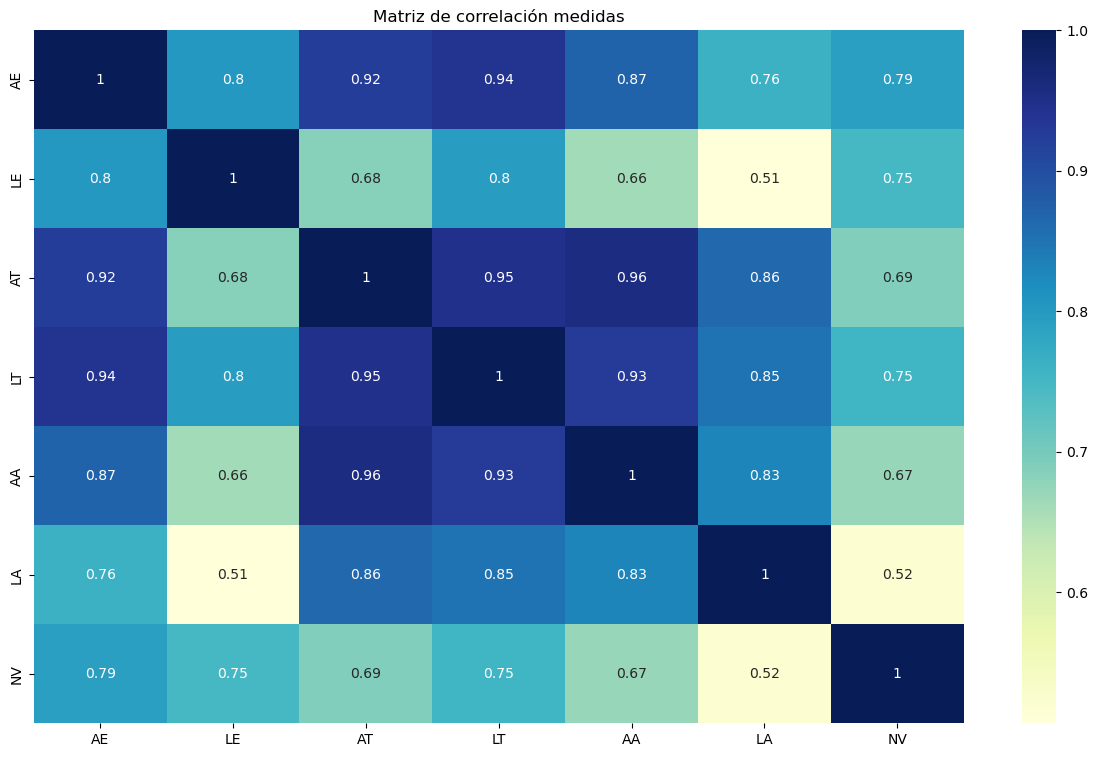

In [69]:
# heatmap para visualizar correlacion lineal entre medidas
corr_mtx(data_5_ratio[medidas], 'medidas')

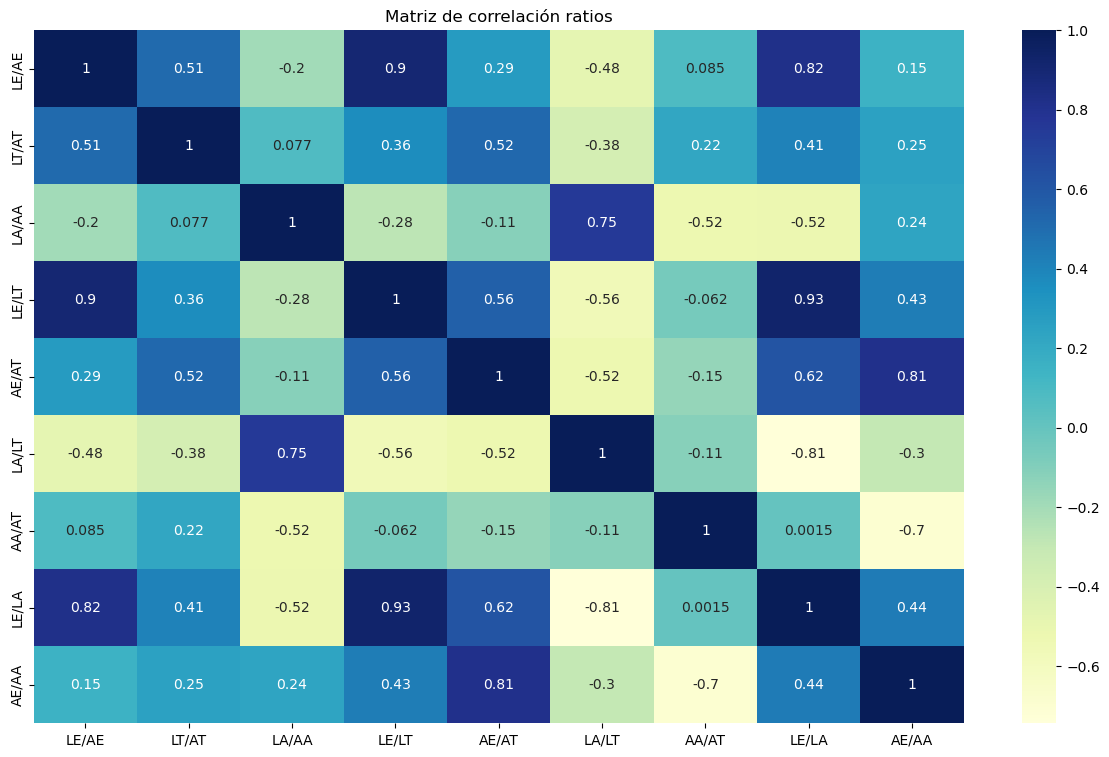

In [68]:
# heatmap para visualizar correlacion lineal entre ratios
corr_mtx(data_5_ratio[ratios], 'ratios')

In [70]:
# definicion de la funcion
def pairplot_variables(mask, v, hue = None, df = data_5_ratio):
    fig = sns.pairplot(
        data = df,
        vars = mask,
        hue = hue,
        plot_kws = {'alpha': 0.5},
        aspect = 1.5)
    fig.savefig(f'../figuras/pairplot_{v}.svg') # guardado de la figura en un archivo vectorial

In [16]:
# # pairplot de medidas para visualizar correlación y dispersión
# pairplot_variables(medidas, 'medidas')

In [17]:
# # pairplot de medidas para visualizar correlación y dispersión entre haplogrupos
# pairplot_variables(medidas, 'medidas_hg', 'haplogrupo')

In [18]:
# # pairplot de ratios para visualizar correlación y dispersión
# pairplot_variables(ratios, 'ratios')

In [19]:
# # pairplot de ratios para visualizar correlación y dispersión entre haplogrupos
# pairplot_variables(ratios, 'ratios_hg', 'haplogrupo')

# 4. Enmascarado del dataset y escalado de *features*

In [20]:
# separación de las variables predictoras
x1 = data_5_ratio[medidas]
x2 = data_5_ratio[ratios]
x3 = data_5_ratio[med_rat]

# instanciado del escalador
scaler = StandardScaler()

# escalado de las variables predictoras
x1_scaled = scaler.fit_transform(x1)
x2_scaled = scaler.fit_transform(x2)
x3_scaled = scaler.fit_transform(x3)

# instanciado de las variables predictoras en dataframes
df_x1 = pd.DataFrame(x1_scaled, index = x1.index, columns = x1.columns)
df_x2 = pd.DataFrame(x2_scaled, index = x2.index, columns = x2.columns)
df_x3 = pd.DataFrame(x3_scaled, index = x3.index, columns = x3.columns)

# 5. Reducción de dimensionalidad

## 5.1. *PCA*

### 5.1.1. Instanciado del modelo y creacion de datasets

In [21]:
# instanciado de pca para cada dataframe
pca_1 = PCA().fit(df_x1)
pca_2 = PCA().fit(df_x2)
pca_3 = PCA().fit(df_x3)

# creado de un dataframe para cada instancia de pca y agregado de la columna 'haplogrupo'
df_pca_1_hg = pd.DataFrame(
    pca_1.fit_transform(df_x1), 
    columns = ['PC' + str(x+1) for x in range(0, len(df_x1.columns))], 
    index = df_x1.index).join(data_5_ratio["haplogrupo"])

df_pca_2_hg = pd.DataFrame(
    pca_2.fit_transform(df_x2), 
    columns = ['PC' + str(x+1) for x in range(0, len(df_x2.columns))], 
    index = df_x2.index).join(data_5_ratio["haplogrupo"])

df_pca_3_hg = pd.DataFrame(
    pca_3.fit_transform(df_x3), 
    columns = ['PC' + str(x+1) for x in range(0, len(df_x3.columns))], 
    index = df_x3.index).join(data_5_ratio["haplogrupo"])

### 5.1.2. Cálculo de pesos (*loadings*) para cada componente principal (*pc*)

In [22]:
# pesos de cada pc para las medidas 
loadings_1 = pd.DataFrame(
    pca_1.components_.T, 
    index = df_x1.columns, 
    columns = ['PC' + str(x+1) for x in range(0, len(df_x1.columns))])

# display de los loadings
loadings_1.iloc[:,:3]

,PC1,PC2,PC3
AE,0.402024,-0.085239,0.038778
LE,0.340264,-0.553736,0.655775
AT,0.401809,0.233265,-0.019414
LT,0.410417,0.058003,0.118027
AA,0.391793,0.246464,-0.034410
LA,0.353230,0.533623,-0.041706
NV,0.338277,-0.531824,-0.742445


In [23]:
# pesos de cada pc para los ratios
loadings_2 = pd.DataFrame(
    pca_2.components_.T, 
    index = df_x2.columns, 
    columns = ['PC' + str(x+1) for x in range(0, len(df_x2.columns))])

# display de los loadings
loadings_2.iloc[:,:3]

,PC1,PC2,PC3
LE/AE,-0.375647,-0.098541,-0.384714
LT/AT,-0.270964,0.025433,-0.605639
LA/AA,0.200825,0.502572,-0.481446
LE/LT,-0.429553,0.013063,-0.101510
AE/AT,-0.357219,0.259301,0.087269
LA/LT,0.388107,0.197225,-0.334331
AA/AT,0.006272,-0.583138,-0.268353
LE/LA,-0.463785,-0.070952,0.081730
AE/AA,-0.259332,0.534485,0.212170


In [24]:
# pesos de cada pc para todas las variables predictoras (medidas originales más ratios)
loadings_3 = pd.DataFrame(
    pca_3.components_.T, 
    index = df_x3.columns, 
    columns = ['PC' + str(x+1) for x in range(0, len(df_x3.columns))])

# display de los loadings
loadings_3.iloc[:,:3]

,PC1,PC2,PC3
AE,-0.339068,0.177127,-0.153925
LE,-0.368391,-0.044894,-0.022767
AT,-0.290665,0.306180,-0.069258
LT,-0.329442,0.230313,-0.070600
AA,-0.287297,0.318126,0.092101
LA,-0.203573,0.366108,-0.195608
NV,-0.323727,0.060751,-0.060701
LE/AE,-0.196267,-0.292532,0.148545
LT/AT,-0.133000,-0.218977,-0.000669
LA/AA,0.181574,0.031730,-0.482338


### 5.1.3. Explicación de la varianza

In [25]:
# definicion de la funcion
def pca_explained_variance(pca, v):
   n = [x+1 for x in range(0, len(pca.components_[0]))] # listadp de los componentes principales
   ev = pca.explained_variance_ratio_ # cálculo de la varianza explicada
   cev = np.cumsum(ev) # cálculo de la varianza explicada acumulada
   fig, ax = plt.subplots() # seteo de figura y eje
   ax.plot(n, ev, '-o', label = 'Individual') # ploteo de la varianza explicada
   ax.plot(n, cev, '-s', label = 'Acumulada') # ploteo de la varianza explicada acumulada
   ax.set(title = f'Varianza explicada {v}',
          xlabel = 'PCs', 
          ylabel = 'Varianza explicada', 
          ylim = (-0.05,1.05)) # seteo de titulo, etiquetas de ejes y límites de y
   ax.legend(loc = 0) # seteo de la leyenda y su localizacion
   for i  in range(0, pca.n_components_): # anotacion de la varianza explicada
      ax.annotate(text = round(cev[i], 2), xy = (i+1, cev[i]), xytext = (i+1, cev[i]+0.025))
   for i  in range(1, pca.n_components_): # anotacion de la varianza explicada acumulada
      ax.annotate(text = round(ev[i], 2), xy = (i+1, ev[i]), xytext = (i+1, ev[i]-0.04))
   fig.savefig(f'../figuras/pca_var_{v}.svg') # guardado de la figura en un archivo vetorial

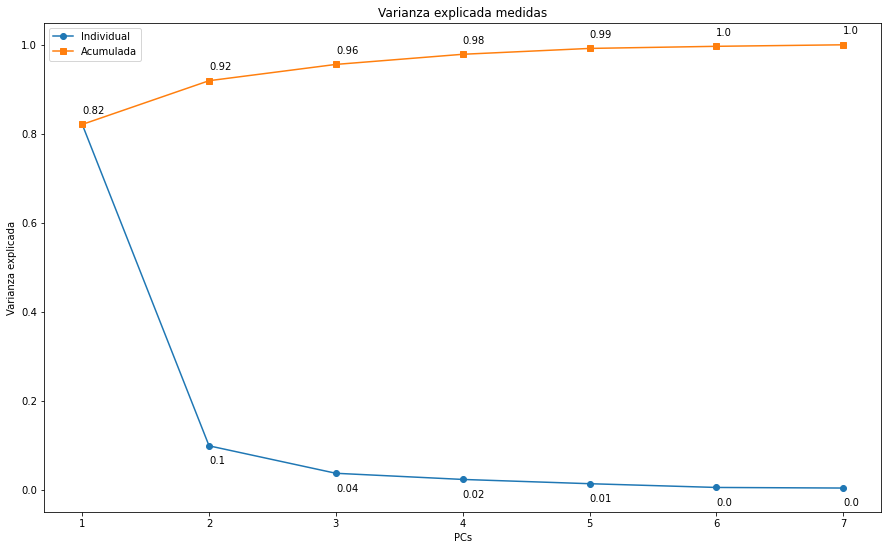

In [26]:
pca_explained_variance(pca = pca_1, v = 'medidas')

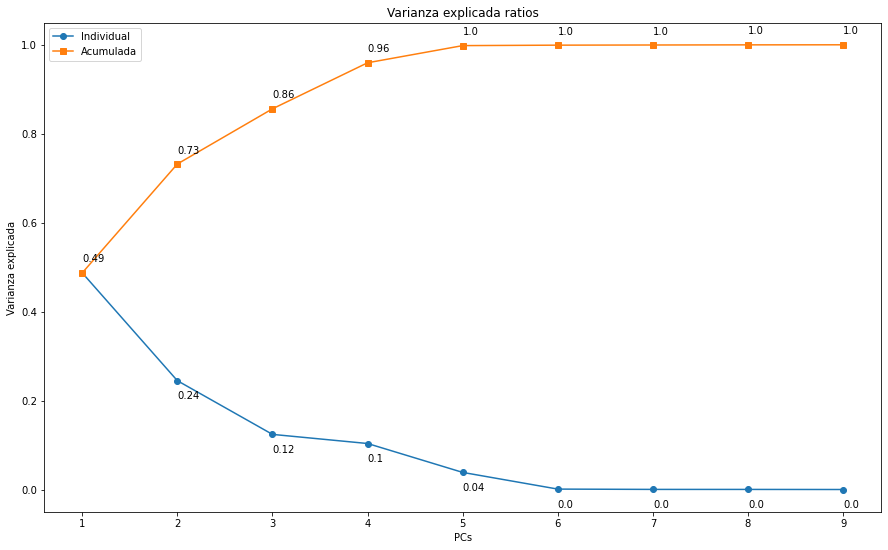

In [27]:
pca_explained_variance(pca = pca_2, v = 'ratios')

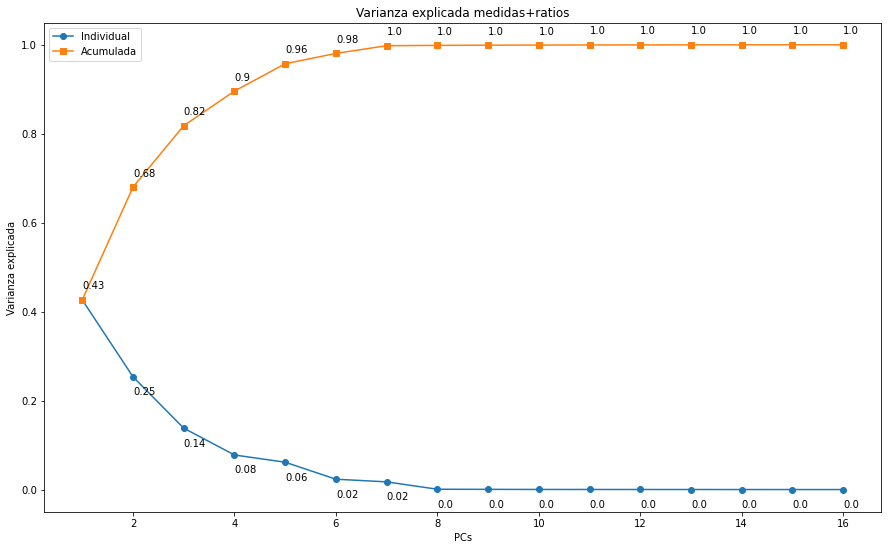

In [28]:
pca_explained_variance(pca = pca_3, v = 'medidas+ratios')

### 5.1.4. Proyección de *PCs*

In [29]:
# definición de la funcion para graficos 2D
def pca_plot_2D(df, loading, v):
    fig, ax0 = plt.subplots() # creacion de la figura y el primer eje
    x_lim, y_lim = max(abs(df['PC1'])), max(abs(df['PC2'])) # creacion de los limites superiores e inferiores para el primer eje
    ax0.set( # seteo del titulo, los limites y las etiquetas 'x' e 'y' del primer eje
        title = f'pca plot {v}',
        xlim = (-x_lim - 0.5, x_lim + 0.5), 
        ylim = (-y_lim - 0.5, y_lim + 0.5), 
        xlabel = 'PC1', 
        ylabel = 'PC2')
    ax0.plot(df.PC1, df.PC2, 'o') # ploteo de los puntos de los PCs 1 y 2 en el primer eje
    ax0.hlines(0, -x_lim - 0.5, x_lim + 0.5, linestyles = 'dotted', colors = 'grey') # creción de la linea de referencia horizontal 
    ax0.vlines(0, -y_lim - 0.5, y_lim + 0.5, linestyles = 'dotted', colors = 'grey') # creción de la linea de referencia vertical
    ax1 = ax0.twinx().twiny() # creacion del segundo eje (identico al primero)
    ax1.set(xlim = (-1, 1), ylim = (-1, 1)) # seteo de los limites del segundo eje
    ax1.set_xlabel('Vectores de pesos', color= 'red') # seteo de la etiqueta 'x' del segundo eje
    for i in loading[['PC1', 'PC2']].index: # anotacion de las variables de acuerdo con sus pesos
        ax1.annotate(i, (loading.PC1.loc[i], loading.PC2.loc[i]), color = 'red')
    for i in range(0, len(loading.index)): # ploteo de los vectores de los pesos
        ax1.arrow(0, 0, loading.PC1[i], loading.PC2[i])
    fig.savefig(f'../figuras/pca_plot_2D_{v}.svg') # guardado de la figura en un archivo vectorial

In [30]:
# definicion de la funcion para graficos 3D
def pca_plot_3D(pca, df, v):
    cev = np.cumsum(pca.explained_variance_ratio_)[2] # calculo de la varianza acumulada
    fig = px.scatter_3d(
        df.fillna('NaN'), # llenado de NaN de la columna 'haplogrupo' para poder colorear
        x = 'PC1', y = 'PC2', z = 'PC3', # deficnicion de los tres ejes
        color = 'haplogrupo', # coloreo de los puntos
        color_discrete_sequence = ['#1c9697', '#f03874', 'gray', '#ffaf6a'],
        opacity = 0.75,
        title = f'Varianza total explicada ({v}): {round(cev*100, 2)}%') # seteo del titulo del grafico
    fig.show() # [!] para sacar el ruido de los NaN clickear sobre el texto 'NaN' en la leyenda
    fig.write_html(f'../figuras/pca_plot_3D_{v}.html') # guardado de la figura en un archivo .html

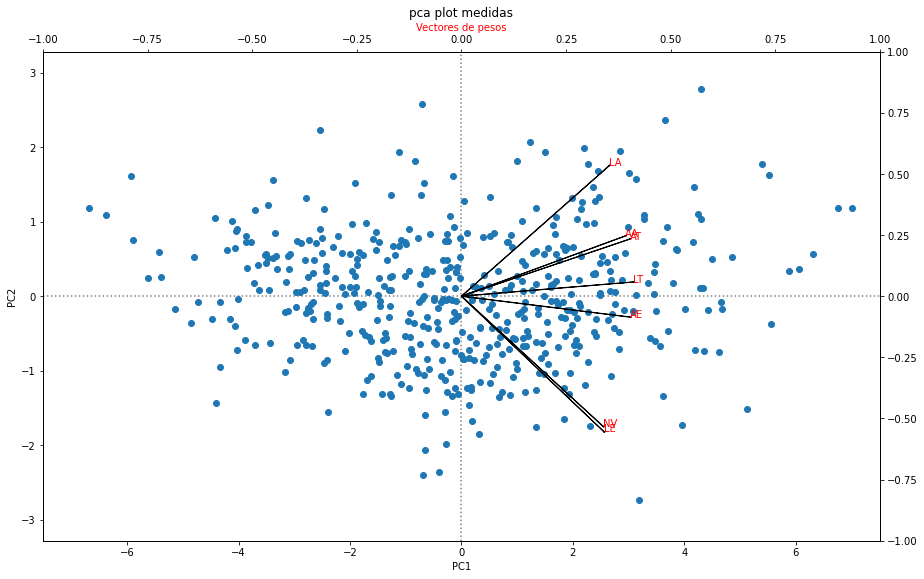

In [31]:
# pca plot 2D y 3D para medidas
pca_plot_2D(df_pca_1_hg, loadings_1, 'medidas')
pca_plot_3D(pca_1, df_pca_1_hg, 'medidas')

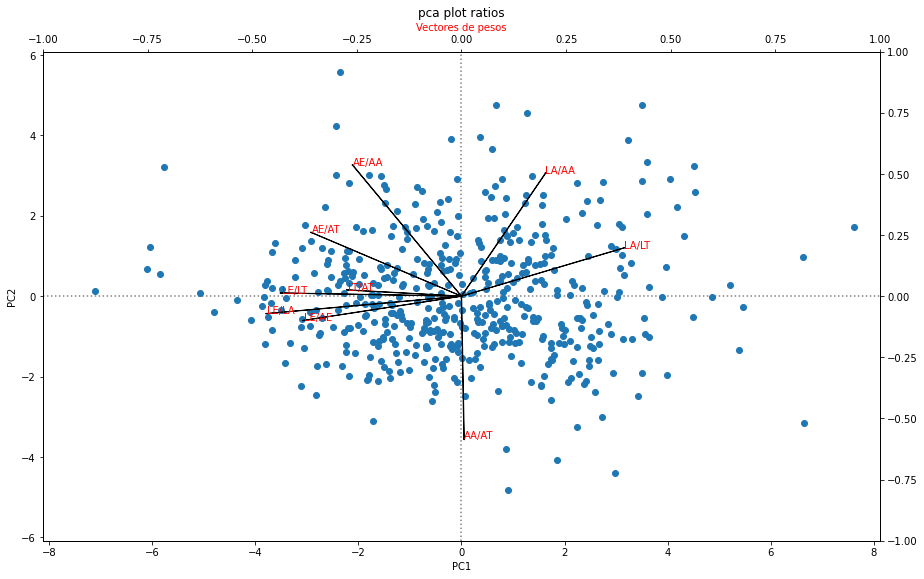

In [32]:
# pca plot 2D y 3D para ratios
pca_plot_2D(df_pca_2_hg, loadings_2, 'ratios')
pca_plot_3D(pca_2, df_pca_2_hg, 'ratios')

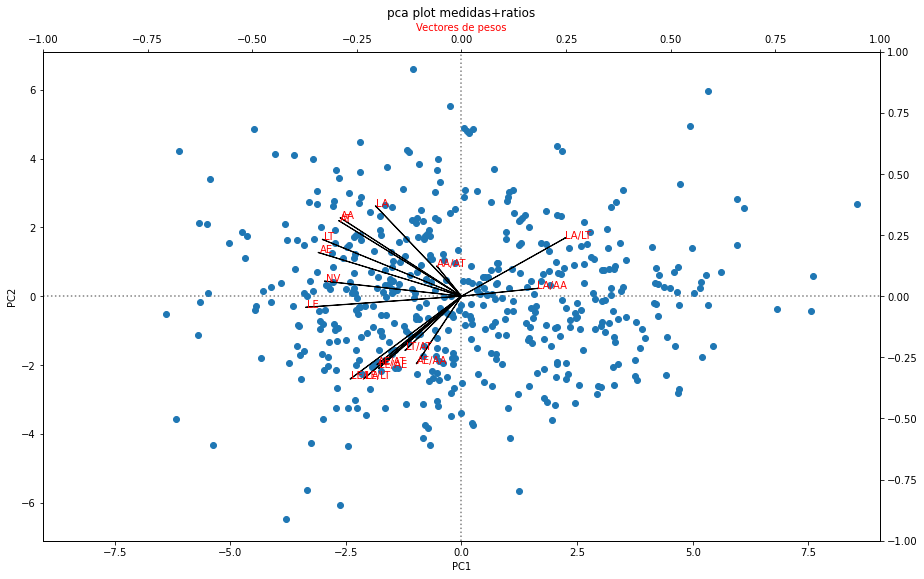

In [33]:
# pca plot 2D y 3D para medidas + ratios
pca_plot_2D(df_pca_3_hg, loadings_3, 'medidas+ratios')
pca_plot_3D(pca_3, df_pca_3_hg, 'medidas+ratios')

## 5.2. *t-SNE*

### 5.2.1. Instanciado del modelo y creacion de datasets

In [34]:
tsne_1 =  TSNE(random_state = 0).fit_transform(df_x1)
tsne_2 =  TSNE(random_state = 0).fit_transform(df_x2)
tsne_3 =  TSNE(random_state = 0).fit_transform(df_x3)

df_tsne_1_hg = pd.DataFrame(tsne_1, columns = ['x', 'y'], index = df_x1.index).join(data_5_ratio["haplogrupo"])
df_tsne_2_hg = pd.DataFrame(tsne_2, columns = ['x', 'y'], index = df_x2.index).join(data_5_ratio["haplogrupo"])
df_tsne_3_hg = pd.DataFrame(tsne_3, columns = ['x', 'y'], index = df_x3.index).join(data_5_ratio["haplogrupo"])

### 5.2.2. Visualización de *t-SNE*

In [35]:
# definicion de la funcion
def tsne_plot(df, v):
    fig, ax = plt.subplots() # creacion de figura y eje
    ax.set( # seteo del titulo y las etiquetas 'x' e 'y'
        title = f't-SNE plot {v}', 
        xlabel = 'x', 
        ylabel = 'y')
    sns.scatterplot( # ploteo de los puntos sobre el eje predefinido
        data = df_tsne_1_hg, 
        x = 'x', 
        y = 'y',  
        ax = ax)
    fig.savefig(f'../figuras/tsne_plot_{v}.svg') # guardado de la figura en un archivo vectorial

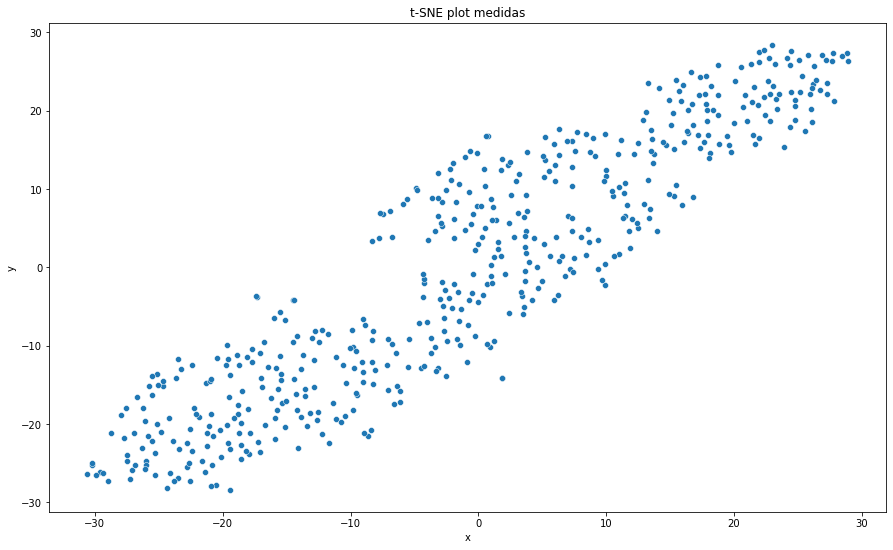

In [36]:
# ploteo de t-sne de medidas
tsne_plot(df_tsne_1_hg, 'medidas')

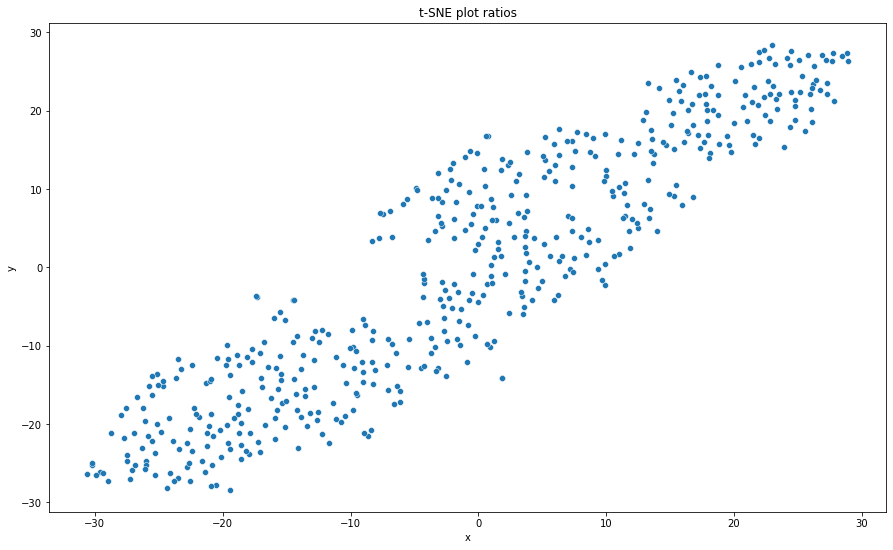

In [37]:
# ploteo de t-sne de ratios
tsne_plot(df_tsne_2_hg, 'ratios')

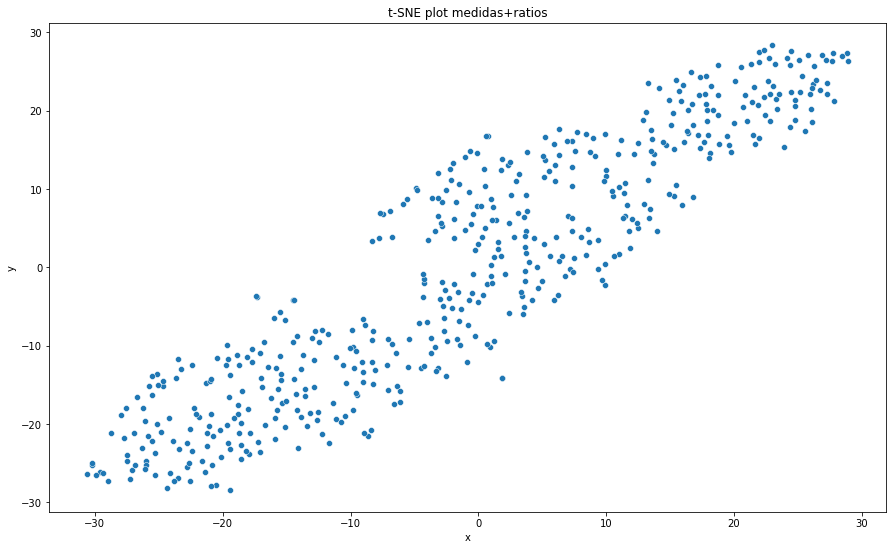

In [38]:
# ploteo de t-sne de medidas+ratios
tsne_plot(df_tsne_2_hg, 'medidas+ratios')

# 6. Clusterización mediante *k-means*

## 6.1. *Silhouette score test* (número de clusters)

In [39]:
# definicion de la funcion
def sil_score_plot(v, x = None, df_pca = None):
    ss = [] # creacion de una lista para almacenar los scores
    k_values = range(2, 10) # definicion de la cantidad de k a calcular
    if x is not None:
        for k in k_values: # bucle de calculo de los kmeans y los silhouette scores para features
            kmeans = KMeans(n_clusters = k, n_init = 10, random_state = 0)
            kmeans.fit(x)
            score = silhouette_score(x, kmeans.labels_)
            ss.append(score)
    else:
        for k in k_values: # bucle de calculo de los kmeans y los silhouette scores para pca
            kmeans = KMeans(n_clusters = k, n_init = 10, random_state = 0)
            kmeans.fit(df_pca.iloc[:,:-1])
            score = silhouette_score(df_pca.iloc[:,:-1], kmeans.labels_)
            ss.append(score)
    fig, ax = plt.subplots() # creacion de figura y eje
    ax.set( # seteo de titulo y etiquetas 'x' e 'y'
        title = f'Silhouette score {v}',
        ylabel = 'Silhouette score',
        xlabel = 'Número de clusters')
    sns.lineplot( # ploteo de los scores
        x = k_values, 
        y = ss, 
        marker = 'o', 
        size = 30, 
        #legend = False, 
        ax = ax)
    fig.savefig(f'../figuras/silhouette_plot_{v}.svg') # guardado de la figura en un archivo vectorial

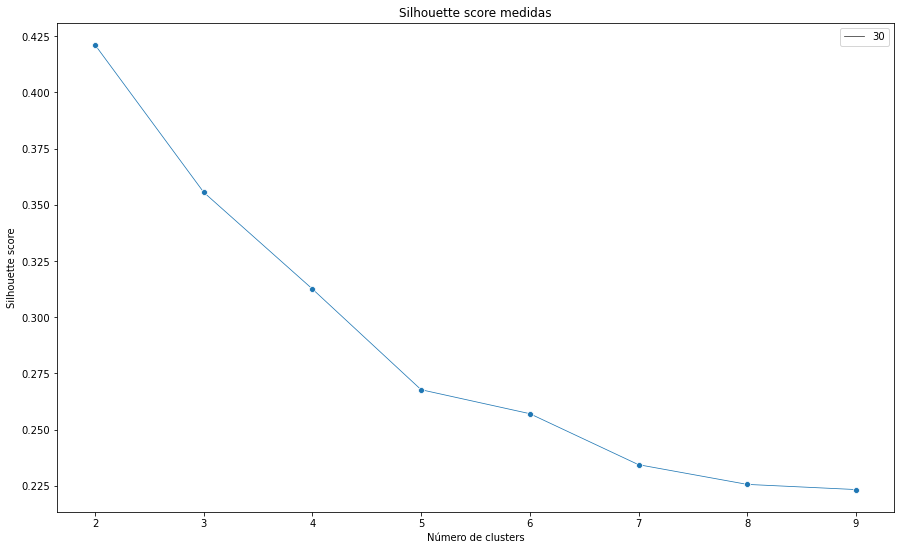

In [40]:
# ploteo de los Silhouette scores para 2 a 20 clusters de medidas
sil_score_plot('medidas', df_pca = df_pca_1_hg)

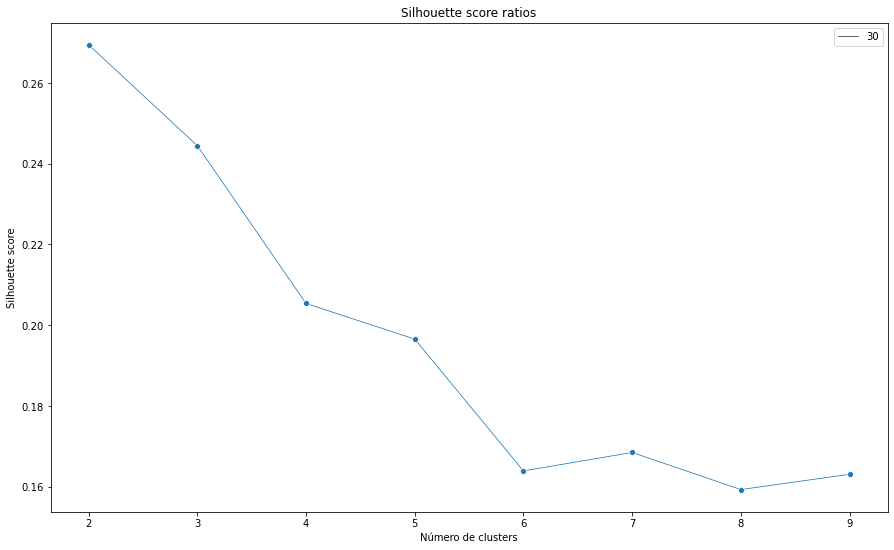

In [41]:
# ploteo de los Silhouette scores para 2 a 20 clusters de ratios
sil_score_plot('ratios', df_pca = df_pca_2_hg)

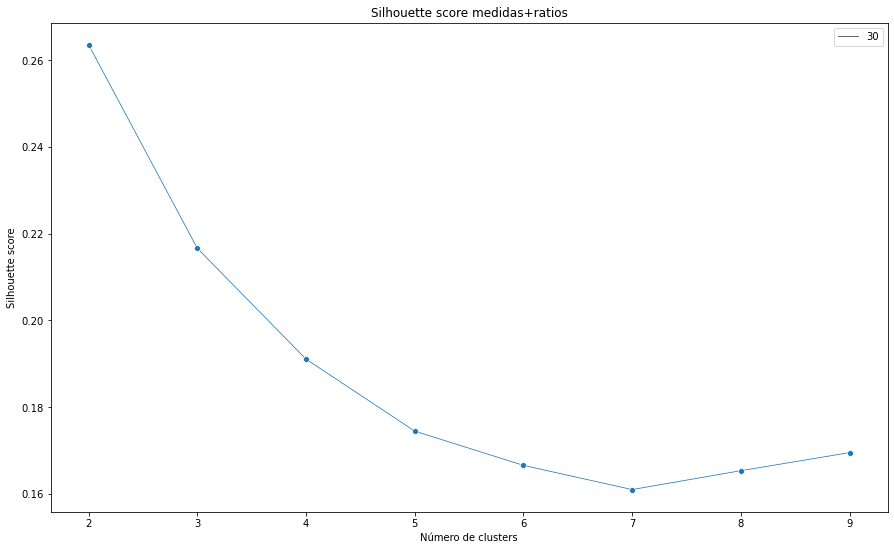

In [42]:
# ploteo de los Silhouette scores para 2 a 20 clusters de medidas+ratios
sil_score_plot('medidas+ratios', df_pca = df_pca_3_hg)

## 6.2. Cálculo y ploteo de clusters 

In [43]:
# definicion de la funcion
def kmeans_plot(df, v):
    kmeans = KMeans( # instanciado del modelo y seteo de hiperparametros
        n_clusters = 3, # numero de clusters a calculat
        n_init = 100, # numero de corridas
        random_state = 0) # seed para repetibilidad
    kmeans.fit(df.iloc[:,:-1]) # ajuste del modelo
    labels = kmeans.labels_ # etiquetas de los clusters
    centroids = kmeans.cluster_centers_ # coordenadas de los centroides
    fig = plt.figure(figsize = (16, 6)) # creacion de figura
    GS = gs.GridSpec(nrows = 1, ncols = 2) # establecimiento de la matriz de ejes
    ax0 = fig.add_subplot(GS[0, 0]) # creacion del eje izquierdo en el subplot [0, 0]
    ax1 = fig.add_subplot(GS[0, 1]) # creacion del eje derecho en el subplot [0, 1]
    sns.scatterplot( # ploteo de los puntos del pca
        data = df,
        x = 'PC1', 
        y = 'PC2', 
        hue = labels, # patron de coloracion de los puntos segun k-means
        legend = 'full', 
        palette = ['#1c9697', '#f03874', '#ffaf6a'],
        ax = ax0) # ubicacion en el eje izquierdo
    ax0.scatter( # ploteo de los centroides
        centroids[:, 0], 
        centroids[:, 1], 
        marker = 'x', 
        s = 50, # tamaño del marcador
        color = 'k')
    ax0.legend(title = 'k-means\nclusters') # seteo del titulo de la leyenda del eje izquierdo
    sns.scatterplot( # ploteo de los puntos del pca
        data = df,
        x = 'PC1', 
        y = 'PC2', 
        hue = 'haplogrupo', # patron de coloracion de los puntos segun los haplogrupos
        legend = 'full', 
        palette = ['#1c9697', '#f03874', '#ffaf6a'],
        ax = ax1) # ubicacion en el eje izquierdo
    fig.savefig(f'../figuras/kmeans_plot_{v}.svg') # guardado de la figura en un archivo vectorial

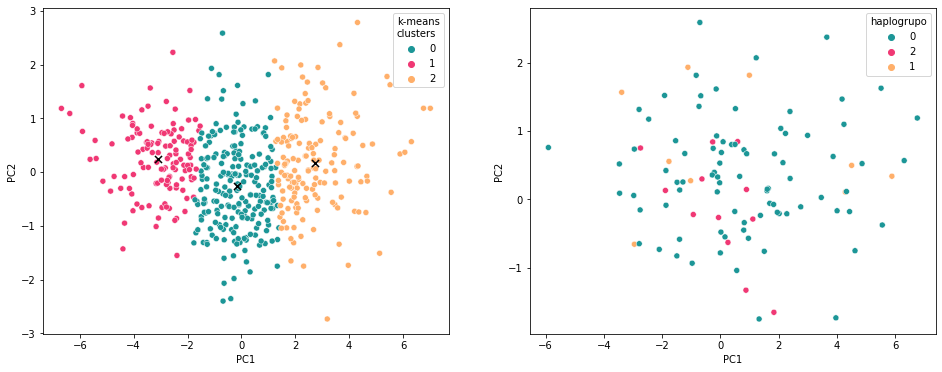

In [44]:
# ploteo de k-means sobre el pca de medidas
kmeans_plot(df_pca_1_hg, 'medidas')

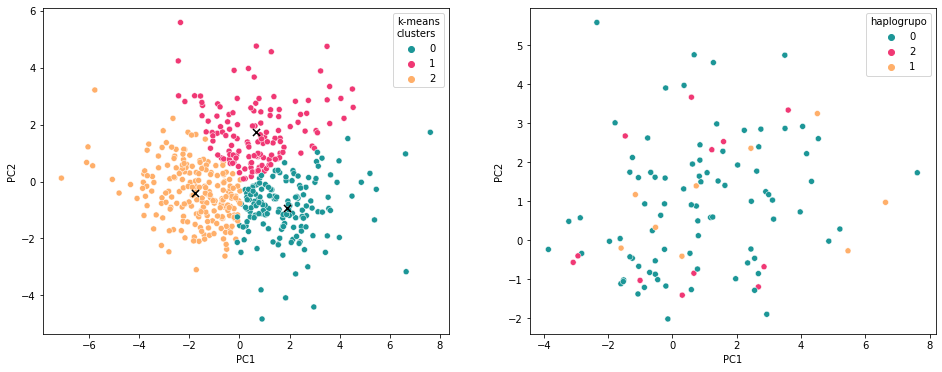

In [45]:
# ploteo de k-means sobre el pca de ratios
kmeans_plot(df_pca_2_hg, 'ratios')

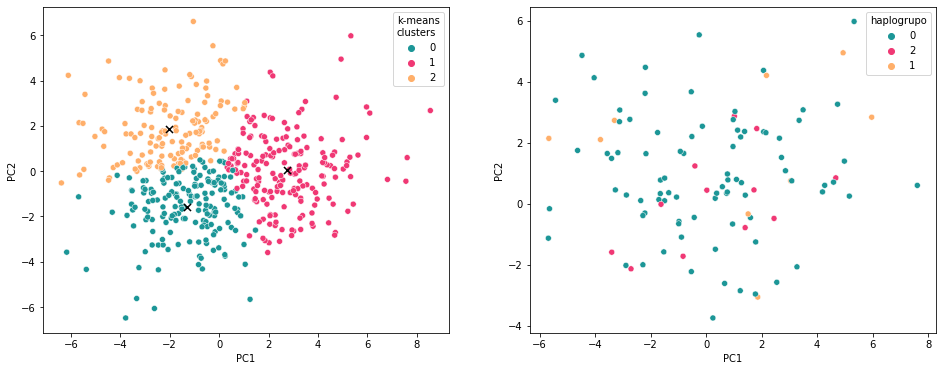

In [46]:
# ploteo de k-means sobre el pca de medidas+ratios
kmeans_plot(df_pca_3_hg, 'medidas+ratios')